### BPIC2011
Bucket: Prefix

Encoding: Index

Classifier: XGBoost

The notebook has all the code for running the benchmark and deriving explanations

In [1]:
import EncoderFactory
from DatasetManager import DatasetManager
import BucketFactory

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lime
import lime.lime_tabular
from lime import submodular_pick;
import warnings
warnings.filterwarnings('ignore')

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def imp_df(column_names, importances):
        df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title, num_feat):
        imp_df.columns = ['feature', 'feature_importance']
        b= sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df.head(num_feat), orient = 'h', palette="Blues_r") 
        b.set_title(title, fontsize = 14) 
    
        for item in b.get_yticklabels():
            item.set_fontsize(13)

In [7]:
def generate_global_explanations(train_X,train_Y, cls, feature_combiner):
    
    print("The number of testing instances is ",len(train_Y))
    print("The total number of columns is",train_X.shape[1]);
    print("The total accuracy is ",cls.score(train_X,train_Y));
       
    sns.set(style="darkgrid")
    sns.set(rc={'figure.figsize':(10,10), "font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    sns.set
    feat_names = feature_combiner.get_feature_names()
    base_imp = imp_df(feat_names, cls.feature_importances_)
    base_imp.head(15)
    #var_imp_plot(base_imp, 'Feature importance using Random forest', 15)
    return base_imp
    

In [8]:
from lime import submodular_pick
def generate_local_explanations(explainer,test_xi, cls,test_y, submod=False, test_all_data=None):
    
    print("Actual value ", test_y)
    num_features=6;# maximum is 6 ,if it is larger than 6, the features displayed are different.
    exp = explainer.explain_instance(test_xi, 
                                 cls.predict_proba, num_features=num_features, labels=[0,1])
    
    #exp.show_in_notebook(show_table=True, show_all=False);
    probability_result=cls.predict_proba([test_xi])[0];
    print(probability_result);
    print ('Explanation for class %s' % class_names[1])
    print ('\n'.join(map(str, exp.as_list(label=1))))
    return exp
    #%matplotlib inline
    #fig = exp.as_pyplot_figure()
        
    if submod==True:
        sp_obj=submodular_pick.SubmodularPick(explainer, test_all_data, cls.predict_proba, 
                                      sample_size=20, num_features=num_features,num_exps_desired=4)
        [exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

In [9]:

dataset_ref = "bpic2011"
params_dir = "params"
results_dir = "results"
bucket_method = "prefix"
cls_encoding = "index"
cls_method = "xgboost"
gap = 1
n_iter = 1

if bucket_method == "state":
    bucket_encoding = "last"
else:
    bucket_encoding = "agg"

method_name = "%s_%s"%(bucket_method, cls_encoding)

dataset_ref_to_datasets = {
    "bpic2011": ["bpic2011_f%s"%formula for formula in range(4,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"]
    #"insurance": ["insurance_activity", "insurance_followup"],
    #"sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]
methods = encoding_dict[cls_encoding]
    
train_ratio = 0.8
random_state = 22

# create results directory
if not os.path.exists(os.path.join(params_dir)):
    os.makedirs(os.path.join(params_dir))
    
print(datasets)

['bpic2011_f4']


In [11]:
from sklearn.metrics import precision_recall_fscore_support
for dataset_name in datasets:
    
    # load optimal params
    optimal_params_filename = os.path.join(params_dir, "optimal_params_%s_%s_%s.pickle" % (cls_method, dataset_name, method_name))
    print(optimal_params_filename)
    if not os.path.isfile(optimal_params_filename) or os.path.getsize(optimal_params_filename) <= 0:
        continue
        
    with open(optimal_params_filename, "rb") as fin:
        args = pickle.load(fin)
        
    print(args)
    bucket_list=[5,10,15,20,25] #:)
    # read the data
    dataset_manager = DatasetManager(dataset_name)
    data = dataset_manager.read_dataset()
    cls_encoder_args = {'case_id_col': dataset_manager.case_id_col, 
                        'static_cat_cols': dataset_manager.static_cat_cols,
                        'static_num_cols': dataset_manager.static_num_cols, 
                        'dynamic_cat_cols': dataset_manager.dynamic_cat_cols,
                        'dynamic_num_cols': dataset_manager.dynamic_num_cols, 
                        'fillna': True}

    # determine min and max (truncated) prefix lengths
    min_prefix_length = 1
    if "traffic_fines" in dataset_name:
        max_prefix_length = 10
    elif "bpic2017" in dataset_name:
        max_prefix_length = min(20, dataset_manager.get_pos_case_length_quantile(data, 0.90))
    else:
        max_prefix_length = min(40, dataset_manager.get_pos_case_length_quantile(data, 0.90))

    # split into training and test
    train, test = dataset_manager.split_data_strict(data, train_ratio, split="temporal")
    
    if gap > 1:
        outfile = os.path.join(results_dir, "performance_results_%s_%s_%s_gap%s.csv" % (cls_method, dataset_name, method_name, gap))
    else:
        outfile = os.path.join(results_dir, "performance_results_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))
        
    start_test_prefix_generation = time.time()
    dt_test_prefixes = dataset_manager.generate_prefix_data(test, min_prefix_length, max_prefix_length)
    test_prefix_generation_time = time.time() - start_test_prefix_generation
            
    offline_total_times = []
    online_event_times = []
    train_prefix_generation_times = []
    explained=False
    impotance=None
    exp_ddict=dict()
    exp_rdict=dict()
    model_dict=dict()
    importance_dict=dict()
    for ii in range(n_iter):
        # create prefix logs
        start_train_prefix_generation = time.time()
        dt_train_prefixes = dataset_manager.generate_prefix_data(train, min_prefix_length, max_prefix_length, gap)
        train_prefix_generation_time = time.time() - start_train_prefix_generation
        train_prefix_generation_times.append(train_prefix_generation_time)
            
        # Bucketing prefixes based on control flow
        bucketer_args = {'encoding_method':bucket_encoding, 
                         'case_id_col':dataset_manager.case_id_col, 
                         'cat_cols':[dataset_manager.activity_col], 
                         'num_cols':[], 
                         'random_state':random_state}
        if bucket_method == "cluster":
            bucketer_args["n_clusters"] = int(args["n_clusters"])
        bucketer = BucketFactory.get_bucketer(bucket_method, **bucketer_args)

        start_offline_time_bucket = time.time()
        bucket_assignments_train = bucketer.fit_predict(dt_train_prefixes)
        offline_time_bucket = time.time() - start_offline_time_bucket

        bucket_assignments_test = bucketer.predict(dt_test_prefixes)

        preds_all = []
        test_y_all = []
        nr_events_all = []
        offline_time_fit = 0
        current_online_event_times = []
        
        for bucket in set(bucket_assignments_test):
            print("Bucket" , bucket )
            #args has only one value - some error and so just using it
            #if bucket_method == "prefix":
            #    current_args = args[bucket]
            #else:
            current_args = args
            relevant_train_cases_bucket = dataset_manager.get_indexes(dt_train_prefixes)[bucket_assignments_train == bucket]
            relevant_test_cases_bucket = dataset_manager.get_indexes(dt_test_prefixes)[bucket_assignments_test == bucket]
            dt_test_bucket = dataset_manager.get_relevant_data_by_indexes(dt_test_prefixes, relevant_test_cases_bucket)
            
            nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_bucket)))
            print('number events', len(nr_events_all))
            
            if len(relevant_train_cases_bucket) == 0:
                preds = [dataset_manager.get_class_ratio(train)] * len(relevant_test_cases_bucket)
                current_online_event_times.extend([0] * len(preds))
            else:
                dt_train_bucket = dataset_manager.get_relevant_data_by_indexes(dt_train_prefixes, relevant_train_cases_bucket) # one row per event
                train_y = dataset_manager.get_label_numeric(dt_train_bucket)

                if len(set(train_y)) < 2:
                    preds = [train_y[0]] * len(relevant_test_cases_bucket)
                    current_online_event_times.extend([0] * len(preds))
                    test_y_all.extend(dataset_manager.get_label_numeric(dt_test_bucket))
                else:
                    start_offline_time_fit = time.time()
                    feature_combiner = FeatureUnion([(method, EncoderFactory.get_encoder(method, **cls_encoder_args)) for method in methods])

                    if cls_method == "rf":
                        cls = RandomForestClassifier(n_estimators=500,
                                                     max_features=current_args['max_features'],
                                                     random_state=random_state)

                    elif cls_method == "xgboost":
                        cls = xgb.XGBClassifier(objective='binary:logistic',
                                                n_estimators=500,
                                                learning_rate= current_args['learning_rate'],
                                                subsample=current_args['subsample'],
                                                max_depth=int(current_args['max_depth']),
                                                colsample_bytree=current_args['colsample_bytree'],
                                                min_child_weight=int(current_args['min_child_weight']),
                                                seed=random_state)

                    elif cls_method == "logit":
                        cls = LogisticRegression(C=2**current_args['C'],
                                                 random_state=random_state)

                    elif cls_method == "svm":
                        cls = SVC(C=2**current_args['C'],
                                  gamma=2**current_args['gamma'],
                                  random_state=random_state)

                    if cls_method == "svm" or cls_method == "logit":
                        pipeline = Pipeline([('encoder', feature_combiner), ('scaler', StandardScaler()), ('cls', cls)])
                    else:
                        pipeline = Pipeline([('encoder', feature_combiner), ('cls', cls)])

                    pipeline.fit(dt_train_bucket, train_y)
                    #get the explainations for the model now
        
                    print("Training model iteration ", ii )
                    
                    #get the training data as a matrix
                    trainingdata=feature_combiner.fit_transform(dt_train_bucket);
                    if bucket in bucket_list:
                        importance = generate_global_explanations(trainingdata,train_y, cls, feature_combiner) 
                        #create an explainer now that can be passed later
                        class_names=['regular','deviant']# regular is 0, deviant is 1, 0 is left, 1 is right
                        explainer = lime.lime_tabular.LimeTabularExplainer(trainingdata,
                                                    feature_names = feature_combiner.get_feature_names(),
                                                   class_names=class_names, discretize_continuous=True)
                        importance_dict[bucket]=importance
                       
                        #exp_dict[bucket]=explainer
                        model_dict[bucket]=cls
                    
                    
                    offline_time_fit += time.time() - start_offline_time_fit

                    # predict separately for each prefix case
                    preds = []
                    
                    test_all_grouped = dt_test_bucket.groupby(dataset_manager.case_id_col)
                    print(dt_test_bucket.shape)
                    count_d=0
                    count_r=0
                    for _, group in test_all_grouped:
                        
                        test_y_group = dataset_manager.get_label_numeric(group)
                        test_y_all.extend(test_y_group)
                            
                        start = time.time()
                        _ = bucketer.predict(group)
                        
                        if cls_method == "svm":
                            pred = pipeline.decision_function(group)
                        else:
                            preds_pos_label_idx = np.where(cls.classes_ == 1)[0][0]
                            pred = pipeline.predict_proba(group)[:,preds_pos_label_idx]
                            #print(test_y_group)
                            if bucket in bucket_list and (count_d<3 or count_r<3):
                                test_x_group= feature_combiner.fit_transform(group)
                                print(test_x_group.shape,test_y_group[0], _)
                                test_x=np.transpose(test_x_group[0])
                                print('Generating local Explanations for', dataset_manager.get_case_ids(group))
                                exp=generate_local_explanations(explainer, test_x, cls, test_y_group )
                                if(test_y_group[0]==1):
                                    count_d=count_d+1
                                    exp_ddict[bucket+count_d]=exp
                                else:
                                    count_r=count_r+1
                                    exp_rdict[bucket+count_r]=exp
                                    
                        pipeline_pred_time = time.time() - start
                        current_online_event_times.append(pipeline_pred_time / len(group))
                        preds.extend(pred)
                        

            preds_all.extend(preds)

      
   
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                print(dataset_name, method_name, cls_method, nr_events, "auc", np.nan)
            else:
                #if nr_events in [5, 10, 25] and explained=False:
                #    generate_local_explanations(explainer,group[j],cls )
                #    explained=True
                print(dataset_name, method_name, cls_method, nr_events, "auc", roc_auc_score(group.actual, group.predicted))
        print(dataset_name, method_name, cls_method, -1, -1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted))
                                 #precision_recall_fscore_support(group.actual, group.predicted))
        
            


params\optimal_params_xgboost_bpic2011_f4_prefix_index.pickle
{'colsample_bytree': 0.6826729672521095, 'learning_rate': 0.32683171551277745, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.8447670591680582}
prefix
Bucket 1
number events 228
Training model iteration  0
(228, 26)
Bucket 2
number events 455
Training model iteration  0
(454, 26)
Bucket 3
number events 673
Training model iteration  0
(654, 26)
Bucket 4
number events 886
Training model iteration  0
(852, 26)
Bucket 5
number events 1093
Training model iteration  0
The number of testing instances is  722
The total number of columns is 1351
The total accuracy is  1.0
(1035, 26)
(1, 1351) 1 [5]
Generating local Explanations for 0    1001_5
Name: Case ID, dtype: object
Actual value  [1]
[0.00202447 0.9979755 ]
Explanation for class deviant
('static__Treatment code_TC803 > 0.00', 0.46344497061134565)
('static__Treatment code_TC813 <= 0.00', -0.16852936921519127)
('static__Treatment code_TC603 <= 0.00', -0.1600126961447724)
(

Bucket 11
number events 2282
Training model iteration  0
(2145, 26)
Bucket 12
number events 2477
Training model iteration  0
(2340, 26)
Bucket 13
number events 2671
Training model iteration  0
(2522, 26)
Bucket 14
number events 2863
Training model iteration  0
(2688, 26)
Bucket 15
number events 3055
Training model iteration  0
The number of testing instances is  540
The total number of columns is 2571
The total accuracy is  1.0
(2880, 26)
(1, 2571) 1 [15]
Generating local Explanations for 0    1001_15
Name: Case ID, dtype: object
Actual value  [1]
[0.00170904 0.99829096]
Explanation for class deviant
('static__Treatment code_TC803 > 0.00', 0.4540413883574598)
('static__Treatment code_TC813 <= 0.00', -0.21296118341022743)
('static__Treatment code_TC603 <= 0.00', -0.19413337129440206)
('static__Treatment code_TC101 <= 0.00', 0.14418647558385594)
('index__weekday_3 <= 1.00', 0.10416423489914252)
('index__event_nr_11 <= 3.00', -0.10114230953194334)
(1, 2571) 1 [15]
Generating local Explana

(1, 3135) 0 [20]
Generating local Explanations for 0    1005_20
Name: Case ID, dtype: object
Actual value  [0]
[0.77525437 0.22474565]
Explanation for class deviant
('static__Treatment code_TC803 <= 0.00', -0.4384886057831619)
('static__Treatment code_TC813 <= 0.00', -0.19411374891714783)
('static__Diagnosis code_M16 <= 0.00', 0.14041204982668926)
('static__Treatment code_TC101 <= 0.00', 0.13831865875371965)
('index__event_nr_11 <= 2.00', -0.10539863308459259)
('static__Specialism code_SC7 <= 0.00', -0.09171456775806605)
(1, 3135) 1 [20]
Generating local Explanations for 0    1006_20
Name: Case ID, dtype: object
Actual value  [1]
[0.9694677  0.03053231]
Explanation for class deviant
('static__Treatment code_TC803 <= 0.00', -0.45423027946849026)
('static__Treatment code_TC813 <= 0.00', -0.2386862433530083)
('static__Treatment code_TC603 <= 0.00', -0.15524231086983975)
('static__Treatment code_TC101 <= 0.00', 0.13040334607998297)
('static__Diagnosis code_M16 <= 0.00', 0.11696911700139533

(1, 3683) 0 [25]
Generating local Explanations for 0    1011_25
Name: Case ID, dtype: object
Actual value  [0]
[9.991229e-01 8.770862e-04]
Explanation for class deviant
('static__Treatment code_TC803 <= 0.00', -0.4880403913189609)
('static__Treatment code_TC813 <= 0.00', -0.18790670585176533)
('static__Treatment code_TC101 <= 0.00', 0.16373258799730803)
('index__event_nr_11 <= 2.00', -0.10241051520096733)
('23.00 < index__event_nr_24 <= 25.00', -0.08163133543400926)
('static__Specialism code_SC7 <= 0.00', -0.07942961029642931)
Bucket 26
number events 5142
Training model iteration  0
(4888, 26)
bpic2011_f4 prefix_index xgboost 1 auc 0.8177188586209684
bpic2011_f4 prefix_index xgboost 2 auc 0.8177821201758672
bpic2011_f4 prefix_index xgboost 3 auc 0.8028917341694973
bpic2011_f4 prefix_index xgboost 4 auc 0.7854295034432766
bpic2011_f4 prefix_index xgboost 5 auc 0.7775661778708818
bpic2011_f4 prefix_index xgboost 6 auc 0.7682963862739143
bpic2011_f4 prefix_index xgboost 7 auc 0.7435975301

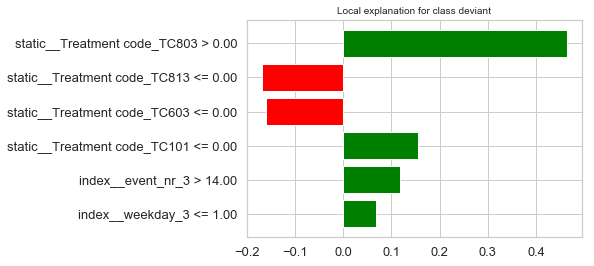

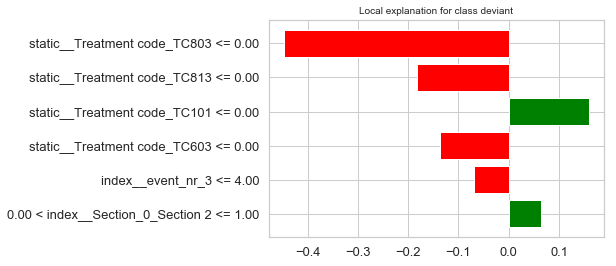

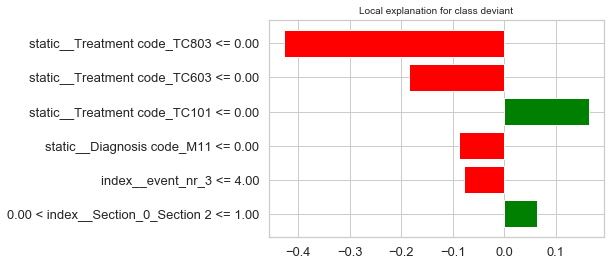

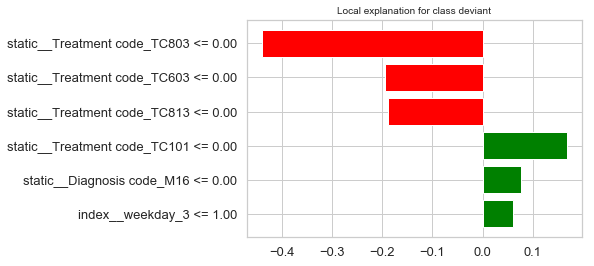

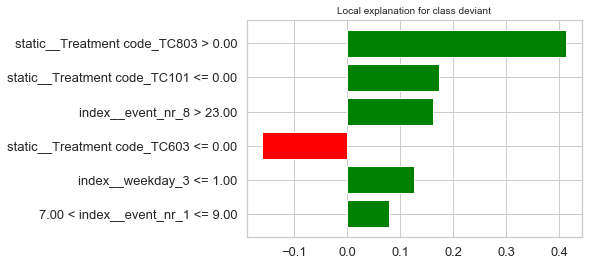

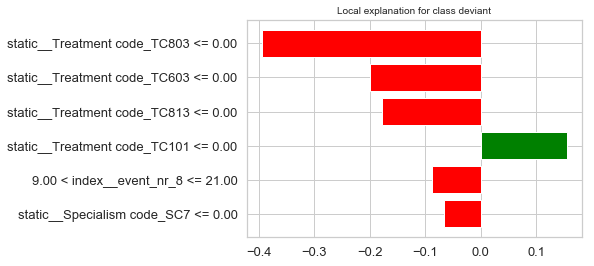

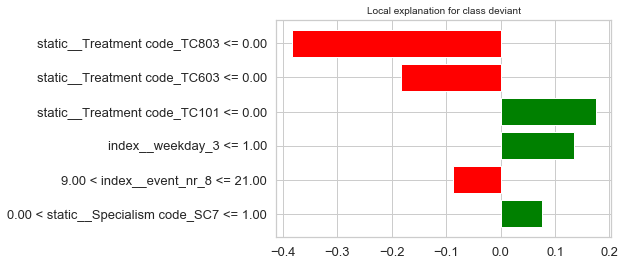

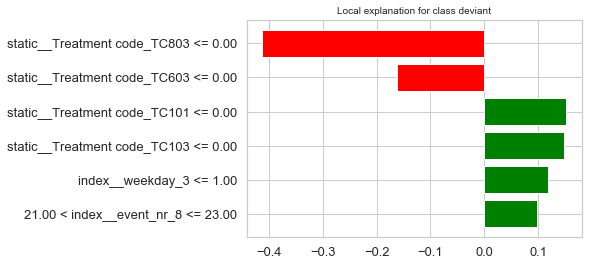

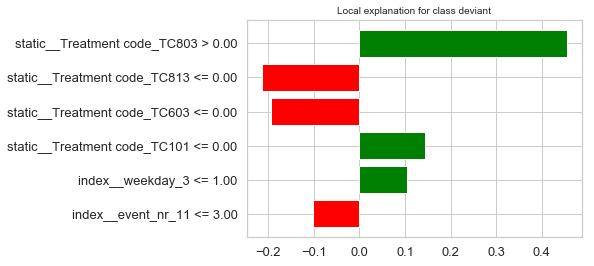

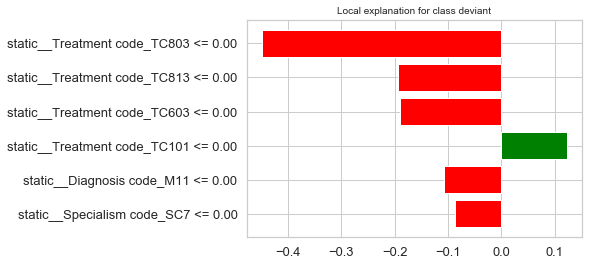

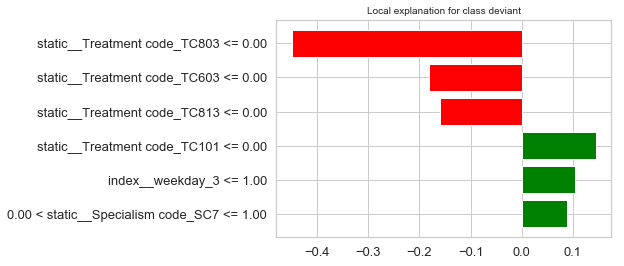

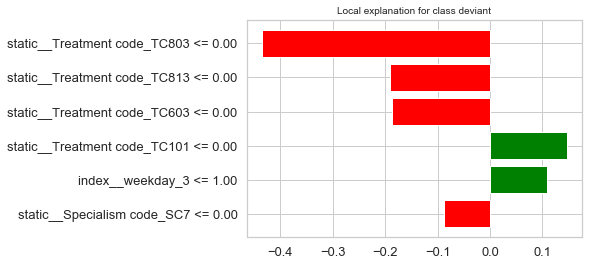

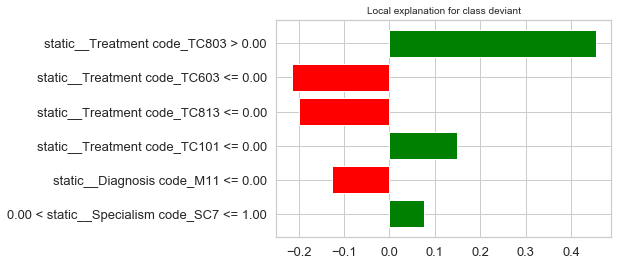

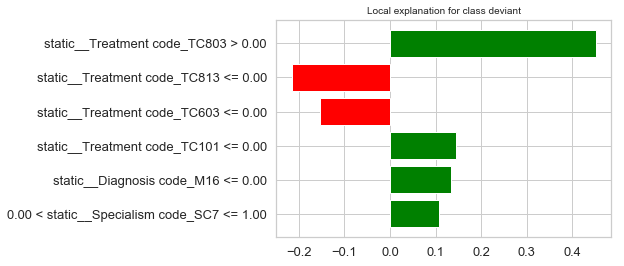

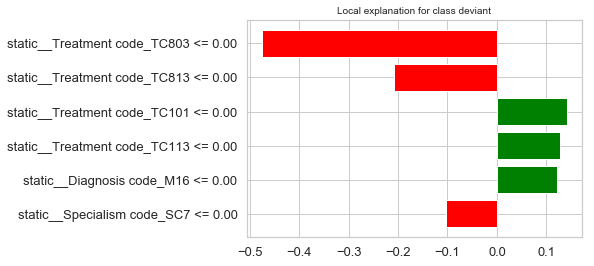

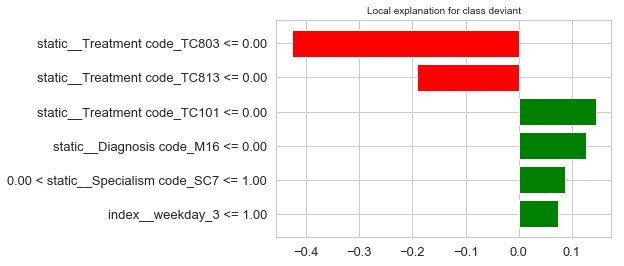

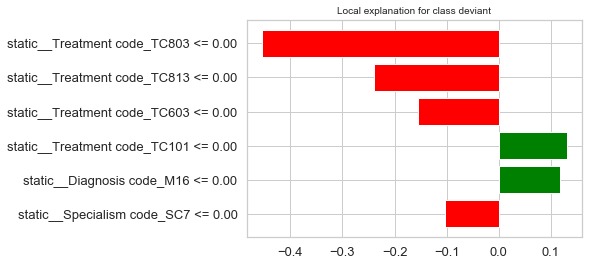

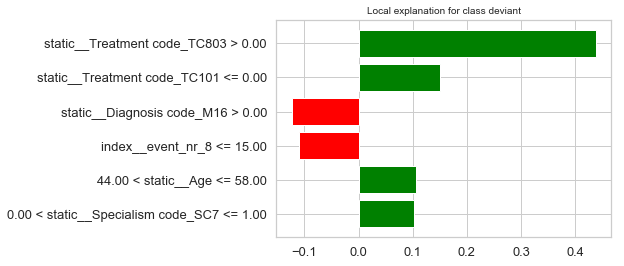

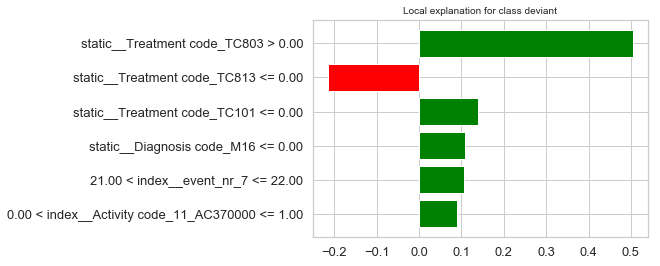

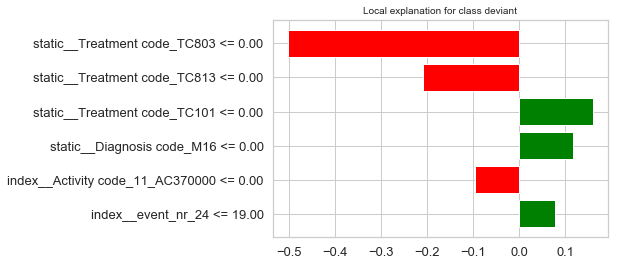

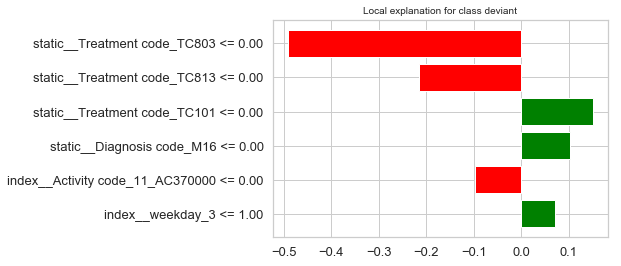

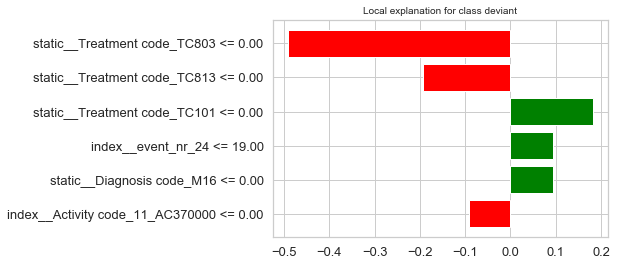

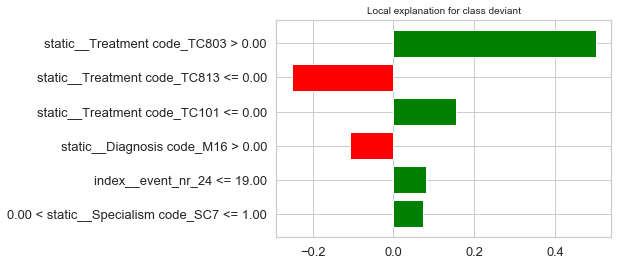

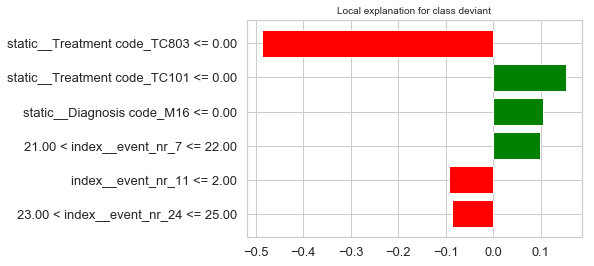

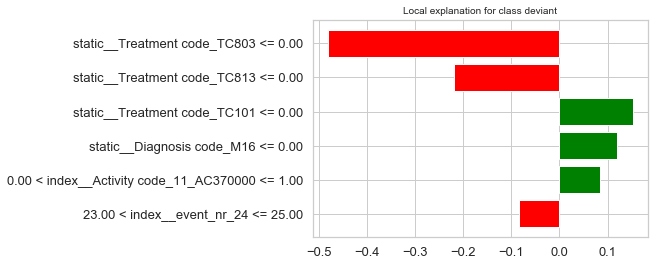

In [12]:
rc={'axes.labelsize': 12, 'xtick.labelsize': 13, 'ytick.labelsize': 13 , 'axes.titlesize': 10}
sns.set(rc)
sns.set_style("whitegrid")
%matplotlib inline
for pre, exp in exp_ddict.items():
    #print('Explanations for prefix length ', pre)
    fig = exp.as_pyplot_figure()

printing global feature importance of the xgboost classifier 25                                feature  feature_importance
0  static__Diagnosis_maligniteit vulva            0.047023
1         static__Treatment code_TC813            0.039417
2          index__Producer code_0_SGEC            0.035341
3       index__Activity code_0_339486E            0.031017
4        static__Treatment code_TC3101            0.029987
5      index__Specialism code.1_0_SC20            0.029372
6             index__group_1_Pathology            0.029144
7         static__Treatment code_TC101            0.029095
8          index__Section_23_Section 2            0.028394
9         static__Treatment code_TC103            0.024221


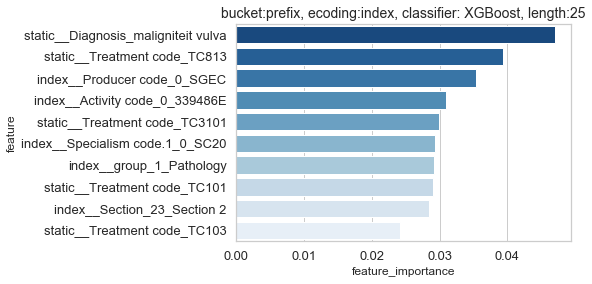

In [18]:
rc={'axes.labelsize': 12, 'xtick.labelsize': 13, 'ytick.labelsize': 13 , 'axes.titlesize': 10}
sns.set(rc)
sns.set_style("whitegrid")

for pre, importance in importance_dict.items():
    if(pre==25):
        print('printing global feature importance of the xgboost classifier', pre, importance.head(10)) 
        var_imp_plot(importance, 'bucket:prefix, ecoding:index, classifier: XGBoost, length:{}'.format(pre), 10)